In [69]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6ihyas75
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6ihyas75
  Resolved https://github.com/albumentations-team/albumentations to commit 972da69c39e5932191e61b6e932d6fef9ca90303
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [70]:
print ("Cloning Dataset Reposotory...\n")
!git clone https://github.com/gangulytrisit/image_segmentation_model.git
print ("Cloning Dataset Reposotory...\n")
print ("Downloading Dataset..\n")
print("Unziping dataset... \n")
!unzip  -oq	image_segmentation_model/Human-Segmentation-Dataset.zip
print("Unzip dataset completed.")

Cloning Dataset Reposotory...

fatal: destination path 'image_segmentation_model' already exists and is not an empty directory.
Cloning Dataset Reposotory...


Unziping dataset... 

Unzip dataset completed.


In [71]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset')

In [72]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [74]:
CSV_FILE='/content/Human-Segmentation-Dataset/train.csv'
DATA_DIR='/content/'
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')
EPOCHS = 6
LR= 0.003
IMAGE_SIZE=320
BATCH_SIZE=16
ENCODER ='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [75]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset/Ground_Truth/1.png,Human-Segmentation-Dataset/Training_Images/1.jpg
1,Human-Segmentation-Dataset/Ground_Truth/10.png,Human-Segmentation-Dataset/Training_Images/10.jpg
2,Human-Segmentation-Dataset/Ground_Truth/100.png,Human-Segmentation-Dataset/Training_Images/100...
3,Human-Segmentation-Dataset/Ground_Truth/101.png,Human-Segmentation-Dataset/Training_Images/101...
4,Human-Segmentation-Dataset/Ground_Truth/102.png,Human-Segmentation-Dataset/Training_Images/102...


In [76]:
index=4
row = df.iloc[index]
image_path=row.images
mask_path = row.masks

image= cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

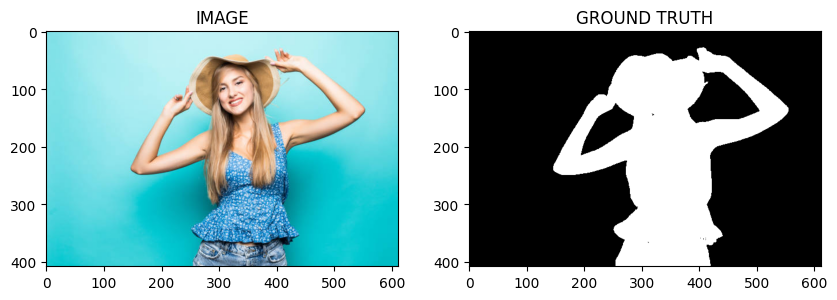

In [77]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [78]:
train_df, val_df = train_test_split(df, test_size=0.2)

In [79]:
import albumentations as A

In [80]:
def get_train_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True,),
                   A.HorizontalFlip(p=0.5),
                   A.VerticalFlip(p=0.5),],is_check_shapes=False) # is_check_shapes=False
def get_val_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True,),],is_check_shapes=False) #is_check_shapes=False

In [81]:
from torch.utils.data import Dataset
class PersonSegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    #mask is in [ h, w] form add channel to it [h, w,c]
    mask = np.expand_dims(mask, axis=-1)

   
    if self.augmentations:
      data=self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # image and mask from [h,w,c]--> [c,h,w]
    image= np.transpose(image,(2,0,1))
    mask= np.transpose(mask,(2,0,1))

   

    image = torch.Tensor(image)/255.0
    mask = torch.Tensor(mask)/255.0

    return image, mask

In [82]:
trainset = PersonSegmentationDataset(train_df, get_train_augs())
validset = PersonSegmentationDataset(val_df, get_val_augs())

In [83]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


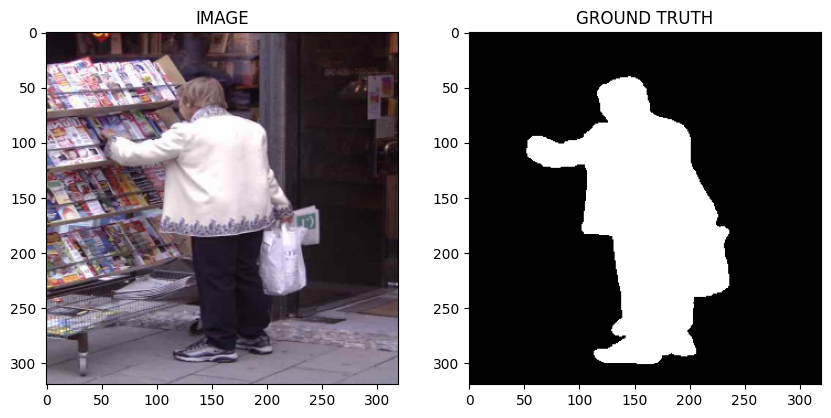

In [84]:
idx=21
image, mask=trainset[idx]
show_image(image,mask)

In [85]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader =  DataLoader(validset,batch_size=BATCH_SIZE,)

In [86]:
print(f'Total number of batches in train loader : {len(trainloader)}')
print(f'Total number of batches in Valid loader : {len(validloader)}')

Total number of batches in train loader : 15
Total number of batches in Valid loader : 4


In [87]:
for image, mask in trainloader:
  break
print(f' One batch image shape {image.shape}')
print(f' One batch mask shape {mask.shape}')

 One batch image shape torch.Size([16, 3, 320, 320])
 One batch mask shape torch.Size([16, 1, 320, 320])


In [88]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [89]:
class PersonSegmentationModel(nn.Module):
  def __init__(self):
    super(PersonSegmentationModel, self).__init__()
    self.arc = smp.Unet(encoder_name=ENCODER,
                        encoder_weights=WEIGHTS,
                        in_channels=3,
                        classes=1,
                        activation=None,
                        )
  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks!=None:
      loss1=DiceLoss(mode='binary')(logits, masks)
      loss2= nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

In [90]:
model=PersonSegmentationModel()
DEVICE = torch.device("cpu")
model.to(DEVICE)

PersonSegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
     

In [91]:
def train_net(dataloader, model, optimizer):
  model.train()
  total_loss = 0.0
  for images, masks in tqdm(dataloader):
    images =images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits , loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss +=loss.item()
  return total_loss/len(dataloader)

In [92]:
def eval_net(dataloader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images =images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits , loss = model(images, masks)
      total_loss +=loss.item()
  return total_loss/len(dataloader)

In [93]:
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

In [94]:
best_valid_loss=np.Inf
for i in range (EPOCHS):
  train_loss=train_net(trainloader, model, optimizer)
  valid_loss= eval_net(validloader, model)
  if valid_loss <best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model saved")
    best_valid_loss=valid_loss
  print(f'ECPOCH : {i+1} Training Loss : {train_loss}, Validation Loss : {valid_loss}')

100%|██████████| 4/4 [00:26<00:00,  6.65s/it]


Model saved
ECPOCH : 1 Training Loss : 0.6764094034830729, Validation Loss : 0.41108084470033646


100%|██████████| 4/4 [00:21<00:00,  5.48s/it]


Model saved
ECPOCH : 2 Training Loss : 0.362805833419164, Validation Loss : 0.3403508812189102


100%|██████████| 4/4 [00:21<00:00,  5.45s/it]


Model saved
ECPOCH : 3 Training Loss : 0.3340987652540207, Validation Loss : 0.26607995480298996


100%|██████████| 4/4 [00:23<00:00,  5.83s/it]


Model saved
ECPOCH : 4 Training Loss : 0.261478125055631, Validation Loss : 0.22163288295269012


100%|██████████| 4/4 [00:23<00:00,  5.96s/it]


Model saved
ECPOCH : 5 Training Loss : 0.23721660375595094, Validation Loss : 0.14590439200401306


100%|██████████| 4/4 [00:23<00:00,  5.85s/it]

ECPOCH : 6 Training Loss : 0.2392271598180135, Validation Loss : 0.1545430924743414


<ipython-input-101-7fe3f23b3663>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


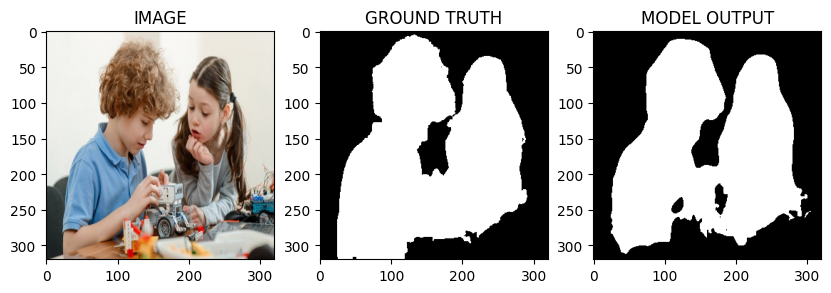

In [101]:
index=9
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[index]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask= torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))